# 格子ボルツマン法による流体シミュレーション (Python)
> 
- toc: true 
- badges: true
- comments: true
- categories: [physics]
- author: 山拓

1年次の時のレポートを記事化したものです。元はProcessingによるシミュレーションでした。

## 格子ボルツマン法
### 計算方法の概要
流体解析（流体シミュレーション, computational fluid dynamics : CFD）を行う上では、連続体である流体の運動を離散化して計算する必要があります。このとき計算する方程式は次式で表される、流体の運動量保存則です.

$$
\begin{aligned}
\rho\frac{D\boldsymbol{v}}{Dt}=-\nabla P+\mu\nabla^2\boldsymbol{v}+\boldsymbol{f}
\end{aligned}
$$

この式はNavier-Stokes方程式と呼ばれます。ここで、$\rho$は密度、$P$は圧力、$\mu$は粘性抵抗、$\boldsymbol{f}$は外力であり、$\dfrac{D\boldsymbol{v}}{Dt}$は流れの速度場$\boldsymbol{v}$のLagrange微分です。よって

$$
\begin{aligned}
\frac{D\boldsymbol{v}}{Dt}=\frac{\partial\boldsymbol{v}}{\partial t}+(\boldsymbol{v}\cdot \nabla)\boldsymbol{v}
\end{aligned}
$$

が成り立ちます。また、質量の保存則として連続の式

$$
\begin{aligned}
\nabla\cdot\boldsymbol{v}=0
\end{aligned}
$$

があります。このような偏微分方程式で表される質量・運動量・エネルギーの保存則を離散化して数値的に解く方法としては有限差分法、有限要素法、有限体積法などがあります。また、流体を粒子の集合に分割し、流体の方程式に従う粒子の動きを計算します方法を粒子法と呼びます。今回用いる格子ボルツマン法（Lattice Boltzmann Method;LBM）とは、これらに属さない方法であり、流体を有限個の種類の速度を持つ仮想的な粒子の集合とみなし、それらの粒子の衝突と並進を計算します。流体を連続体ではなく粒子として扱う点は粒子法に似ていますが、LBMではあくまでも仮想的な粒子の分布を扱います。質量・運動量・エネルギーの保存則を巨視的（マクロ）な方程式であるとすれば、LBMが解く方程式は統計熱力学に基づく微視的 (ミクロ) な方程式と言えます。

### LBMの格子
LBMの格子は2次元では正方形、3次元では立方体を用いることが多いです。今回は、2次元平面における流れを考えるため、2D9Qモデルを用います。''2D''というのは2次元である事を意味し、''9Q''は粒子の取りうる速度$\boldsymbol{c}_i$の方向が9つあることを示しています (下図：LBMの格子(2D9Q)と9方向の速度 ($c=1$のとき))。

![Lattice2D9Q](images/lattice_boltzmann_figs/Lattice2D9Q.svg)

9つの速度は
$$
\begin{aligned}
\boldsymbol{c}_0&=(0,0)\ \ (i=0)\\
\boldsymbol{c}_i&=c\left[\cos\left(\frac{i-1}{2}\pi\right), \sin\left(\frac{i-1}{2}\pi\right)\right]\ \ (i=1,2,3,4)\\
\boldsymbol{c}_i&=\sqrt{2}c\left[\cos\left(\frac{i-1}{2}\pi+\frac{\pi}{4}\right), \sin\left(\frac{i-1}{2}\pi+\frac{\pi}{4}\right)\right]\ \ (i=5,6,7,8)
\end{aligned}
$$

で表されます。ここで$c$は定数ですが、実装上は簡単のため$c=1$とします。なお、この2D9Qモデルですが、数式で表記する場合には数字で方向をラベリングするほうがよいです。逆に実装する上では方角による方向のラベリングを行う方がミスがなくなりやすいでしょう (下図：2D9Q のラベリング)。

![Lattice](images/lattice_boltzmann_figs/Lattice.svg)

### 時間発展の式
座標$\boldsymbol{x}=(x,y)$、時刻$t$において速度$\boldsymbol{c}_i$を持つ粒子についての速度分布関数(確率密度関数)を$f_i(\boldsymbol{x},t)$とします。この速度分布関数$f_i(\boldsymbol{x},t)$は以下の格子ボルツマン方程式 (lattice Boltzmann equation) に従います.

$$
\begin{aligned}
\underbrace{f_i(\boldsymbol{x}+\boldsymbol{c}_i\Delta t,t+\Delta t)-f_i(\boldsymbol{x},t)}_{並進\textrm{(streaming)}}=\underbrace{\Omega_i[f_i(\boldsymbol{x},t)]}_{衝突\textrm{(collision)}}
\end{aligned}\tag{1}
$$

ただし、$\Delta t$は時間刻みです。速度$\boldsymbol{c}_i$の粒子は$\Delta t$で空間刻み$\Delta \boldsymbol{x}=\boldsymbol{c}_i\Delta t$だけ離れた格子に移動します。(1)式は初期条件さえ与えれば速度分布関数$f_i(\boldsymbol{x},t)$を陽的に計算できます。また上式の左辺は粒子の並進(streaming)を表し、右辺は粒子同士の衝突(collision)を表します。並進は下図のように計算します。

![streaming](images/lattice_boltzmann_figs/streaming.svg)

実装上では$\Omega_i$の取り扱いが重要とりますが、BGK (Bhatnagar-Gross-Krook)近似に基づく衝突則を用いられることが多いです。BGK近似モデルを用いたLBMの基礎方程式は次式で表されます。

$$
\begin{aligned}
f_i(\boldsymbol{x}+\boldsymbol{c}_i\Delta t,t+\Delta t)-f_i(\boldsymbol{x},t)=-\frac{1}{\tau}[f_i(\boldsymbol{x},t)-f_i^{\textrm{eq}}(\boldsymbol{x},t)]
\end{aligned}\tag{2}
$$

ここで、$\tau$は単一緩和時間です。 実装上は$\omega:=\dfrac{1}{\tau}$とします。なお、粘度（動粘性抵抗）$\nu$と単一緩和時間$\tau$および$\omega$との間には

$$
\tau=\frac{1}{\omega}\approx 3\nu+0.5\Delta t
$$

が成り立ちます。

### 平衡分布関数の計算
(2)式中の$f_i^{\textrm{eq}}(\boldsymbol{x},t)$を平衡分布関数と呼びます。ここでMaxwell-Boltzmann平衡分布は次式で表されます。

$$
g^{\textrm{eq}}(\boldsymbol{\xi})=\rho{\left(\frac{m}{2\pi k_BT}\right)}^{\frac{D}{2}} \exp\left(-\frac{m(\boldsymbol{c}_i-\boldsymbol{v})^2}{2k_BT}\right)\ \
$$

ただし、$\boldsymbol{\xi}:=\boldsymbol{c}_i-\boldsymbol{v}$とし、$D$ は次元数としました。上式を$\boldsymbol{v}$についてTayler展開することで平衡分布関数は求められ、次式で表されます。

$$
\begin{aligned}
f_i^{\textrm{eq}}(\boldsymbol{x},t)=w_i\rho\left[1+\frac{3(\boldsymbol{c}_i\cdot\boldsymbol{v})}{c^2}+\frac{9}{2c^4}(\boldsymbol{c}_i\cdot\boldsymbol{v})^2-\frac{3}{2c^2}\boldsymbol{v}^2\right]
\end{aligned}\tag{3}
$$

ただし、

$$
  w_i = \begin{cases}
    \frac{4}{9} & (i=0) \\
    \frac{1}{9} & (i=1, 2, 3, 4) \\
    \frac{1}{36} & (i=5, 6, 7, 8) \\
  \end{cases}
$$

です。この$f_i^{\textrm{eq}}(\boldsymbol{x},t)$の計算のために密度$\rho(\boldsymbol{x},t)$と流速$\boldsymbol{v}(\boldsymbol{x},t)=(v_x(\boldsymbol{x},t), v_y(\boldsymbol{x},t))$を計算する必要がありますが、これらは次のように$f_i(\boldsymbol{x},t)$から求めることができます。

$$
\begin{align}
\rho(\boldsymbol{x},t)&=\sum_{i=0}^{8}f_i(\boldsymbol{x},t)\tag{4}\\
v_x(\boldsymbol{x},t)&=\frac{1}{\rho}\left[(f_1+f_5+f_8)-(f_3+f_6+f_7)\right]\tag{5}\\
v_y(\boldsymbol{x},t)&=\frac{1}{\rho}\left[(f_2+f_5+f_6)-(f_4+f_7+f_8)\right]\tag{6}
\end{align}
$$

これより、仮想粒子の速度$\boldsymbol{c}_i$と流速$\boldsymbol{v}(\boldsymbol{x}、t)$の内積$(\boldsymbol{c}_i\cdot\boldsymbol{v})$の計算ができます。また$c=1$とするので、最終的な実装上の式は次のようになります.

$$
\begin{array}[H]{c||c|c}
i&(\boldsymbol{c}_i\cdot\boldsymbol{v})&f_i^{\textrm{eq}}(\boldsymbol{x},t)\\ \hline
0&0&\frac{4}{9}\rho\left[1-\frac{3}{2}\boldsymbol{v}^2\right]\\
1(E)&v_x&\frac{1}{9}\rho\left[1+3v_x+\frac{9}{2}v_x^2-\frac{3}{2}\boldsymbol{v}^2\right]\\
2(N)&v_y&\frac{1}{9}\rho\left[1+3v_y+\frac{9}{2}v_y^2-\frac{3}{2}\boldsymbol{v}^2\right]\\
3(W)&-v_x&\frac{1}{9}\rho\left[1-3v_x+\frac{9}{2}v_x^2-\frac{3}{2}\boldsymbol{v}^2\right] \\
4(S)&-v_y&\frac{1}{9}\rho\left[1-3v_y+\frac{9}{2}v_y^2-\frac{3}{2}\boldsymbol{v}^2\right]\\
5(NE)&v_x+v_y&\frac{1}{36}\rho\left[1+3(v_x+v_y)+\frac{9}{2}(v_x+v_y)^2-\frac{3}{2}\boldsymbol{v}^2\right]\\
6(NW)&-v_x+v_y&\frac{1}{36}\rho\left[1+3(-v_x+v_y)+\frac{9}{2}(-v_x+v_y)^2-\frac{3}{2}\boldsymbol{v}^2\right]\\
7(SW)&-v_x-v_y&\frac{1}{36}\rho\left[1-3(v_x+v_y)+\frac{9}{2}(v_x+v_y)^2-\frac{3}{2}\boldsymbol{v}^2\right]\\
8(SE)&v_x-v_y&\frac{1}{36}\rho\left[1+3(v_x-v_y)+\frac{9}{2}(v_x-v_y)^2-\frac{3}{2}\boldsymbol{v}^2\right]\\ \hline
\end{array}
$$


### 境界条件
粒子と障壁(barrier)との衝突を考えます。滑りなし壁の条件($\boldsymbol{v}=0$)を簡易に実装するために用いられているのが、**bounce-back条件** です。障害物に指定された格子点に仮想粒子が並進運動で侵入した場合、bounce-back条件では、仮想粒子をその侵入方向と180°反対の方向に跳ね返します (次図)。なお、今回は障害物の境界は格子点の中央に存在するとします。

![bounceback](images/lattice_boltzmann_figs/bounceback.svg)

### 計算のアルゴリズム
アルゴリズムは以下のようになります.

1. 密度$\rho$, 流速$\boldsymbol{v}$, 速度分布関数$f_i$, 平衡分布関数$f$を初期化します。今回の場合は、左から右に流れが生じている場合を考えるので$\boldsymbol{v}$は$x$方向のみ大きさを持ちます。また、計算開始前、分布関数は平衡に達していたとします。よって次式のようになります。

    $$
    \begin{align}
    \rho(\boldsymbol{x},t)&:=1\tag{7}\\
    \boldsymbol{v}(\boldsymbol{x},t)=(v_x, v_y)&:=(u,0)\ \ (u:定数)\tag{8}\\
    f_i(\boldsymbol{x},t=0)&:=f_i^{\textrm{eq}}(\boldsymbol{x},t=0)\tag{9}\\
    \end{align}
    $$

1. 密度$\rho$, 流速$\boldsymbol{v}$を$f_i(\boldsymbol{x},t)$から(4), (5), (6)式によって求めます。
1. 平衡分布関数$f_i^{\textrm{eq}}(\boldsymbol{x},t)$を(3)式より計算します。

1. (**Streaming Step**) (2)式の左辺により、並進後の分布関数を次のように計算します。

    $$
    \begin{aligned}
    f_i(\boldsymbol{x}+\boldsymbol{c}_i\Delta t,t+\Delta t)=f_i^*(\boldsymbol{x},t)\\
    \end{aligned}\tag{10}
    $$

1. (**Bounce Step**) 5において並進した格子に障害物（境界）が存在した場合、bounce-back条件により、修正します。

1. (**Collision Step**) 仮想粒子の衝突を(2)式の右辺により次のように計算します。ただし、$f_i^*(\boldsymbol{x},t)$は仮想粒子が衝突し、並進する前の分布関数です。

    $$
    \begin{aligned}
    f_i^*(\boldsymbol{x},t)=f_i(\boldsymbol{x},t)-\frac{1}{\tau}[f_i(\boldsymbol{x},t)-f_i^{\textrm{eq}}(\boldsymbol{x},t)]\\
    \end{aligned}\tag{11}
    $$

1. 2～6を繰り返します。

## Pythonでの実装
ここからはPythonでの実装について解説していきます。なお、コードは[Fluid Dynamics Simulation](http://physics.weber.edu/schroeder/fluids/)を参考にしています。Processing版はOpenProcessingで公開しています (<https://www.openprocessing.org/sketch/497312/>)。

ライブラリをimportします。このとき、`%matplotlib nbagg`を付ければipynb上でアニメーションが実行できます。

In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

各種定数を定義していきます。

In [2]:
# Define constants:
height = 80 # lattice dimensions
width = 200
viscosity = 0.02 # fluid viscosity
omega = 1 / (3*viscosity + 0.5) # "relaxation" parameter
u0 = 0.1  # initial and in-flow speed
four9ths = 4.0/9.0 # abbreviations for lattice-Boltzmann weight factors
one9th   = 1.0/9.0
one36th  = 1.0/36.0

格子の初期化を(3)式に基づいて行います。

In [3]:
# Initialize all the arrays to steady rightward flow:
n0 = four9ths * (np.ones((height,width)) - 1.5*u0**2) # particle densities along 9 directions
nN = one9th * (np.ones((height,width)) - 1.5*u0**2)
nS = one9th * (np.ones((height,width)) - 1.5*u0**2)
nE = one9th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nW = one9th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nNE = one36th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nSE = one36th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nNW = one36th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nSW = one36th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW # macroscopic density
ux = (nE + nNE + nSE - nW - nNW - nSW) / rho # macroscopic x velocity
uy = (nN + nNE + nNW - nS - nSE - nSW) / rho # macroscopic y velocity

障害物の位置を初期化します。このとき、障害物内の粒子の数は0とします。

In [4]:
# Initialize barriers:
barrier = np.zeros((height,width), bool) # True wherever there's a barrier
barrier[int((height/2)-8):int((height/2)+8), int(height/2)] = True			# simple linear barrier
barrierN = np.roll(barrier,  1, axis=0) # sites just north of barriers
barrierS = np.roll(barrier, -1, axis=0) # sites just south of barriers
barrierE = np.roll(barrier,  1, axis=1) # etc.
barrierW = np.roll(barrier, -1, axis=1)
barrierNE = np.roll(barrierN,  1, axis=1)
barrierNW = np.roll(barrierN, -1, axis=1)
barrierSE = np.roll(barrierS,  1, axis=1)
barrierSW = np.roll(barrierS, -1, axis=1)

Streaming StepとBounce-back stepです。`np.roll`により仮想粒子を移動させます。このとき, 粒子の進行方向と逆向きの順で格子を選び, 分布関数を更新します.

In [5]:
# Move all particles by one step along their directions of motion (pbc):
def stream():
    global nN, nS, nE, nW, nNE, nNW, nSE, nSW
    nN  = np.roll(nN,   1, axis=0)	# axis 0 is north-south; + direction is north
    nNE = np.roll(nNE,  1, axis=0)
    nNW = np.roll(nNW,  1, axis=0)
    nS  = np.roll(nS,  -1, axis=0)
    nSE = np.roll(nSE, -1, axis=0)
    nSW = np.roll(nSW, -1, axis=0)
    nE  = np.roll(nE,   1, axis=1)	# axis 1 is east-west; + direction is east
    nNE = np.roll(nNE,  1, axis=1)
    nSE = np.roll(nSE,  1, axis=1)
    nW  = np.roll(nW,  -1, axis=1)
    nNW = np.roll(nNW, -1, axis=1)
    nSW = np.roll(nSW, -1, axis=1)
    # Use tricky boolean arrays to handle barrier collisions (bounce-back):
    nN[barrierN] = nS[barrier]
    nS[barrierS] = nN[barrier]
    nE[barrierE] = nW[barrier]
    nW[barrierW] = nE[barrier]
    nNE[barrierNE] = nSW[barrier]
    nNW[barrierNW] = nSE[barrier]
    nSE[barrierSE] = nNW[barrier]
    nSW[barrierSW] = nNE[barrier]

Collide stepの関数を定義します。

In [6]:
# Collide particles within each cell to redistribute velocities (could be optimized a little more):
def collide():
    global rho, ux, uy, n0, nN, nS, nE, nW, nNE, nNW, nSE, nSW
    rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW
    ux = (nE + nNE + nSE - nW - nNW - nSW) / rho
    uy = (nN + nNE + nNW - nS - nSE - nSW) / rho
    ux2 = ux * ux # pre-compute terms used repeatedly...
    uy2 = uy * uy
    u2 = ux2 + uy2
    omu215 = 1 - 1.5*u2 # "one minus u2 times 1.5"
    uxuy = ux * uy
    n0 = (1-omega)*n0 + omega * four9ths * rho * omu215
    nN = (1-omega)*nN + omega * one9th * rho * (omu215 + 3*uy + 4.5*uy2)
    nS = (1-omega)*nS + omega * one9th * rho * (omu215 - 3*uy + 4.5*uy2)
    nE = (1-omega)*nE + omega * one9th * rho * (omu215 + 3*ux + 4.5*ux2)
    nW = (1-omega)*nW + omega * one9th * rho * (omu215 - 3*ux + 4.5*ux2)
    nNE = (1-omega)*nNE + omega * one36th * rho * (omu215 + 3*(ux+uy) + 4.5*(u2+2*uxuy))
    nNW = (1-omega)*nNW + omega * one36th * rho * (omu215 + 3*(-ux+uy) + 4.5*(u2-2*uxuy))
    nSE = (1-omega)*nSE + omega * one36th * rho * (omu215 + 3*(ux-uy) + 4.5*(u2-2*uxuy))
    nSW = (1-omega)*nSW + omega * one36th * rho * (omu215 + 3*(-ux-uy) + 4.5*(u2+2*uxuy))
    # Force steady rightward flow at ends (no need to set 0, N, and S components):
    nE[:,0] = one9th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nW[:,0] = one9th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nNE[:,0] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nSE[:,0] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nNW[:,0] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nSW[:,0] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)

次に流速$\boldsymbol{v}$の回転$\textrm{rot}\ \boldsymbol{v}$の$z$成分を計算する関数を定義します。$\textrm{rot}\ \boldsymbol{v}$の$z$成分は

$$
(\textrm{rot}\ \boldsymbol{v})_z=\frac{\partial v_y}{\partial x}-\frac{\partial v_x}{\partial y}
$$

で表されます。偏微分項の中心差分を取ると,

$$
(\textrm{rot}\ \boldsymbol{v})_z\approx\frac{v_y(x+\epsilon,y)-v_y(x-\epsilon, y)}{2\epsilon}-\frac{v_x(x, y+\epsilon)-v_x(x, y-\epsilon)}{2\epsilon}
$$

となります。流れの速度場が格子状に離散化されていることから, $\epsilon=1$とすべきであるので次式のように計算されます。

$$
(\textrm{rot}\ \boldsymbol{v})_z\approx\frac{v_y(x+1,y)-v_y(x-1, y)}{2}-\frac{v_x(x, y+1)-v_x(x, y-1)}{2}
$$

なお、実装上は2で割ることを省略しています。

In [7]:
# Compute rot of the macroscopic velocity field:
def rot(ux, uy):
    return np.roll(uy,-1,axis=1) - np.roll(uy,1,axis=1) - np.roll(ux,-1,axis=0) + np.roll(ux,1,axis=0)

シミュレーションのメインの関数です。`nextFrame`関数を実行することでシミュレーションが進行します。

<IPython.core.display.Javascript object>


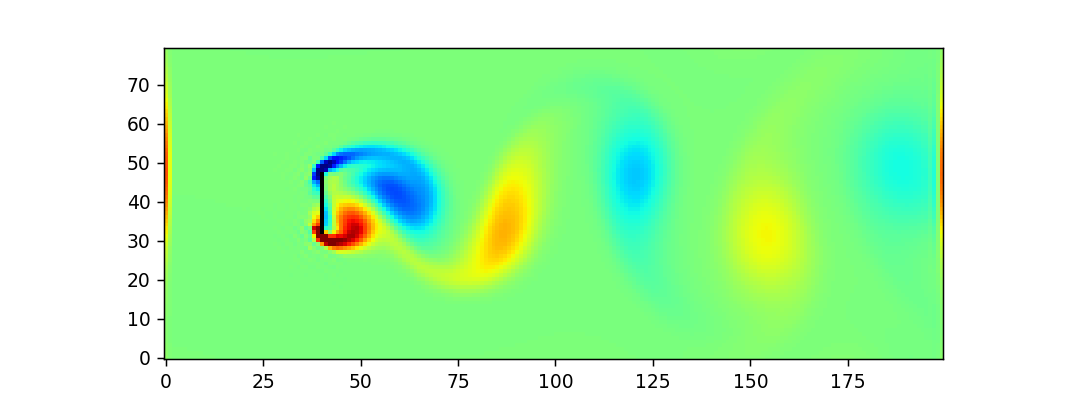

In [8]:
# Here comes the graphics and animation
theFig = plt.figure(figsize=(8,3))
fluidImage = plt.imshow(rot(ux, uy), origin='lower', norm=plt.Normalize(-.1,.1), 
                        cmap=plt.get_cmap('jet'), interpolation='none')

bImageArray = np.zeros((height, width, 4), np.uint8)
bImageArray[barrier,3] = 255
barrierImage = plt.imshow(bImageArray, origin='lower', interpolation='none')

def nextFrame(arg):
    for step in range(20):
        stream()
        collide()
    fluidImage.set_array(rot(ux, uy))
    return (fluidImage, barrierImage) # return the figure elements to redraw

animate = animation.FuncAnimation(theFig, nextFrame, interval=1, blit=True)
plt.show()

## 参考文献
- Schroeder, D., [Fluid Dynamics Simulation](http://physics.weber.edu/schroeder/fluids/),  (2018年1月30日閲覧)
- Guo, Z. and Shu, C., 2013, Lattice Boltzmann method and its applications in engineering, World Scientific (Singapore)
- 蔦原 道久, 他2名, 1999, 『格子気体法・格子ボルツマン法―新しい数値流体力学の手法』, コロナ社
- 太田 光浩, 他4名, 2015, 『混相流の数値シミュレーション 』, 丸善出版
- Bao, Y. and Meskas, J.,  2011。[Lattice Boltzmann Method for Fluid Simulations](https://cims.nyu.edu/~billbao/report930.pdf), (2018年1月30日閲覧)
- 立石 絢也, 樫山 和男, 2006, 「非圧縮性粘性流体解析のためのCIVA-格子ボルツマン法の精度と安定性」, 『日本計算工学会論文集』, 2006年度号, No.20060008